# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Environment Set-Up

In [1]:
# Environment Set-Up (Import of libraries etc.)
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, countDistinct, when, col, desc, udf, col, sort_array, asc, avg, from_unixtime, lit, last
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time

%matplotlib inline

In [46]:
# Start-Up Spark
spark = SparkSession \
    .builder \
    .appName("Sparkify Project Local") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [47]:
# Read in the dataset
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [48]:
# Get an overview of the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [49]:
# Check how the data looks like
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [50]:
# Check for missing values
df_missing = df.select([count(when((col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c)).alias(c) \
                            for c in df.columns])
df_missing.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We see here that there are a lot of missing values of userIds artists, names etc. This is because **for some entries the userId is an empty string**. These are data that we cannot take into account for the rest of the analysis, as we cannot identify which user it is that made the request. The data will be dropped and we will check again for missing values.

In [51]:
# Filter out entries without user id
df = df.filter(df.userId != '')

In [52]:
# Check for missing values again
df_missing = df.select([count(when((col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c)).alias(c) \
                            for c in df.columns])
df_missing.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



The remaining missing values are for the fields artist, length and song. Regarding artist and sond this is expected as not all requests should contain a specific song. The length missing for some requests will be left for now as missing value. If we need to use this information in our further analysis, we will resolve the issue.

In [55]:
# Just take a look for requests with missing length
df.filter(df.length.isNull()).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [56]:
# Check which pages have null length
df.select(df.length, df.page) \
            .filter(df.length.isNull()) \
            .groupby(df.page).count() \
            .withColumn('percent', col('count')/Fsum('count').over(Window.partitionBy())) \
            .orderBy('count', ascending=False) \
            .show(5)

+---------------+-----+-------------------+
|           page|count|            percent|
+---------------+-----+-------------------+
|      Thumbs Up|12551| 0.2507892738680414|
|           Home|10082|0.20145466171122567|
|Add to Playlist| 6526|0.13040003197058705|
|     Add Friend| 4277|0.08546137553450825|
|    Roll Advert| 3933| 0.0785876993166287|
+---------------+-----+-------------------+
only showing top 5 rows



Below we get the summary statistics of all other numeric values. **No further abnormalities are identified**

In [53]:
# Get summary statistics for numeric values
df_sum = df.select([item[0] for item in df.dtypes if not item[1].startswith('string')]).describe().show()

+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|           length|        registration|         sessionId|            status|                  ts|
+-------+------------------+-----------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|           228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.1171819778458|1.535358834084427...|1042.5616241362698|209.10321620397335|1.540958915431871...|
| stddev|  129.851729399489|99.23517921058361| 3.291321616327586E9| 726.5010362219813|30.151388851328214|1.5068287123306298E9|
|    min|                 0|          0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|       3024.66567|       1543247354000|              2474|               404|      

# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [54]:
# Get the number of individual users in the dataset
df.select('userId').distinct().count()

225

In [57]:
# Calculate the percentages of different type of requests
pages_df_pd = df.select(df.page) \
            .groupby(df.page).count() \
            .orderBy('count') \
            .withColumn('percent', col('count')/Fsum('count').over(Window.partitionBy())) \
            .orderBy('percent') \
            .toPandas()

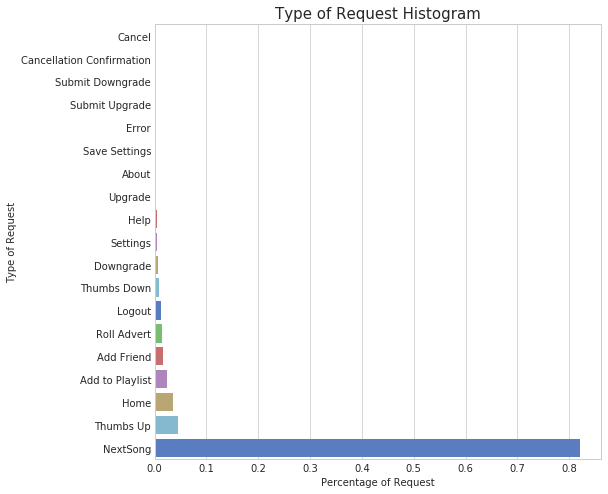

In [58]:
# Create a barplot of the above percentages
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(y=pages_df_pd['page'].tolist(), x='percent', data=pages_df_pd, ci=None, palette="muted",orient='h', )
ax.set_title("Type of Request Histogram", fontsize=15)
ax.set_xlabel ("Percentage of Request")
ax.set_ylabel ("Type of Request")
plt.show();

**As expected the next song request dominates the dataset with 82%.**

In [59]:
# Get number of users by location
df.dropDuplicates(["userId"]) \
        .groupBy('location') \
        .count() \
        .orderBy('count', ascending = False) \
        .show(5)

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Phoenix-Mesa-Scot...|    7|
|Dallas-Fort Worth...|    7|
|Chicago-Napervill...|    6|
+--------------------+-----+
only showing top 5 rows



In most locations there are too few users, and many location contain just one user. This does not allow to extract safe conclusions for many of the locations and was decided not to further use location in the model.

In [60]:
# Get count by gender
df_ch_sex_count = df.dropDuplicates(["userId"]).groupBy('gender').count()
df_ch_sex_count.show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In this regard we will calculate the churn based on the Cancellation Confirmation request. Users who did this request will be flagged as users who churned in the df_churned datadrame.

In [61]:
# Calculate which users churned

# Function to identify which row contains the Cancellation Confirmation request
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Indentify the churn request and if a user has made such a request flag him as churned
df_churned = df.withColumn("churn_event", flag_churn_event("page")) \
        .groupBy('userId') \
        .agg({'churn_event':'max'}) \
        .withColumnRenamed('max(churn_event)', 'Churned')

# Join the churn flag with original dataframe
df_ch = df.join(df_churned, ['userId'], 'left')

In [62]:
# Number of users who did churn
df_churned.filter(df_churned.Churned == 1).count()

52

In [63]:
# Get count by level
df_level_count = df_ch.dropDuplicates(["userId"]).groupBy('level').count()
# Get count by level
df_gender_count = df_ch.dropDuplicates(["userId"]).groupBy('gender').count()

# Get percentages churn by level
df_ch_level_gender = df_ch.dropDuplicates(["userId"]) \
        .groupBy(['level', 'gender']) \
        .agg({'Churned':'count'}) \
        .withColumnRenamed('count(Churned)', 'Churn') \
        .orderBy('level')
df_ch_level_gender.show()

+-----+------+-----+
|level|gender|Churn|
+-----+------+-----+
| free|     M|  100|
| free|     F|   77|
| paid|     M|   21|
| paid|     F|   27|
+-----+------+-----+



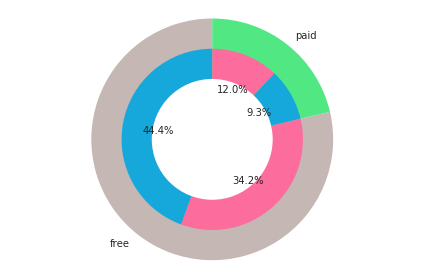

In [64]:
# Create a double pie chart by gender and level of subscription
labels_level = [x['level'] for x in df_level_count.select('level').distinct().collect()]
sizes_level = [x['count'] for x in df_level_count.select('count').collect()]
labels_gender = len(sizes_level)*[x['gender'] for x in df_gender_count.select('gender').distinct().collect()]
sizes_gender = [x['Churn'] for x in df_ch_level_gender.select('Churn').collect()]
colors = ['#C5B7B4', '#51E783']
colors_gender = len(sizes_level)*['#17A8DB','#FC6C9C']
 
plt.pie(sizes_level, labels=labels_level, startangle=90, colors=colors, frame=True)
plt.pie(sizes_gender, radius=0.75,startangle=90, colors=colors_gender, autopct='%1.1f%%')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [65]:
# Get a column of the date for each request
df_ch = df_ch.withColumn('date', from_unixtime(col('ts')/1000, 'dd/MM/yyyy'))

In [66]:
df_ch.show(1)

+------+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+-------+----------+
|userId|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|Churned|      date|
+------+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+-------+----------+
|    30|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|      0|01/10/2018|
+------+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-----------

In [67]:
# Get average churn users by location
df_ch.groupBy('location') \
        .agg({'Churned':'avg'}) \
        .show()

+--------------------+-------------------+
|            location|       avg(Churned)|
+--------------------+-------------------+
|     Gainesville, FL|                0.0|
|Atlantic City-Ham...|                0.0|
|Deltona-Daytona B...|                0.0|
|San Diego-Carlsba...|0.46286472148541113|
|Cleveland-Elyria, OH|                1.0|
|Kingsport-Bristol...|                0.0|
|New Haven-Milford...|                0.0|
|Birmingham-Hoover...|                1.0|
|  Corpus Christi, TX|                1.0|
|         Dubuque, IA|                0.0|
|Las Vegas-Henders...|                0.0|
|Indianapolis-Carm...| 0.9463917525773196|
|Seattle-Tacoma-Be...|                0.0|
|          Albany, OR|                1.0|
|   Winston-Salem, NC|                0.0|
|     Bakersfield, CA|                0.0|
|Los Angeles-Long ...|   0.18841060701603|
|Minneapolis-St. P...|                0.0|
|San Francisco-Oak...| 0.2534945221004911|
|Phoenix-Mesa-Scot...|0.05179529508873298|
+----------

In [68]:
# Get count of Request by request type and churn
cols_to_check = [x.page for x in df_ch.select('page').distinct().collect()]
for colu in cols_to_check:
    print('Column: {}'.format(colu))
    df_ch.filter(df_ch.page == colu).groupBy('Churned') \
            .count() \
            .show() 
    print()

Column: Cancel
+-------+-----+
|Churned|count|
+-------+-----+
|      1|   52|
+-------+-----+


Column: Submit Downgrade
+-------+-----+
|Churned|count|
+-------+-----+
|      1|    9|
|      0|   54|
+-------+-----+


Column: Thumbs Down
+-------+-----+
|Churned|count|
+-------+-----+
|      1|  496|
|      0| 2050|
+-------+-----+


Column: Home
+-------+-----+
|Churned|count|
+-------+-----+
|      1| 1672|
|      0| 8410|
+-------+-----+


Column: Downgrade
+-------+-----+
|Churned|count|
+-------+-----+
|      1|  337|
|      0| 1718|
+-------+-----+


Column: Roll Advert
+-------+-----+
|Churned|count|
+-------+-----+
|      1|  967|
|      0| 2966|
+-------+-----+


Column: Logout
+-------+-----+
|Churned|count|
+-------+-----+
|      1|  553|
|      0| 2673|
+-------+-----+


Column: Save Settings
+-------+-----+
|Churned|count|
+-------+-----+
|      1|   58|
|      0|  252|
+-------+-----+


Column: Cancellation Confirmation
+-------+-----+
|Churned|count|
+-------+-----+
| 

It is observed that users who did not churn have had more interaction of different types with the platform.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [69]:
# Create dummy variable for the gender
gender_dummy = df_ch.groupBy('userId').pivot('gender').agg(lit(1)).na.fill(0)
gender_dummy.show(5)

+------+---+---+
|userId|  F|  M|
+------+---+---+
|100010|  1|  0|
|200002|  0|  1|
|   125|  0|  1|
|    51|  0|  1|
|     7|  0|  1|
+------+---+---+
only showing top 5 rows



In [70]:
df_actions = df_ch.groupBy('userId') \
        .pivot('page') \
        .count() \
        .na.fill(0)
df_actions.show(2)

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
|100010|    1|         4|              7|     0|                        0|        0|    0|   2|  11|     5|     275|         52|            0|  

In [71]:
# Calculate average day usage duration of the service for each user
df_day_dur = df_ch.groupBy('userId', 'date').agg({'ts':'min'}) \
    .join(df_ch.groupBy('userId', 'date').agg({'ts':'max'}) , ['userId', 'date']) \
    .withColumn('Day_Duration', (col('max(ts)') - col('min(ts)')) / 1000) \
    .groupBy('userId').agg({'Day_Duration' : 'avg'}) \
    .withColumnRenamed('avg(Day_Duration)', 'Day_Duration')
df_day_dur.show(5)

+------+------------------+
|userId|      Day_Duration|
+------+------------------+
|200002| 13668.57142857143|
|100010|            9269.0|
|   125|            1774.0|
|   124| 38627.30303030303|
|    51|43809.692307692305|
+------+------------------+
only showing top 5 rows



In [72]:
# Calculate average number of songs per day for each user
df_day_songs = df_ch.filter(df_ch.song.isNotNull()).groupBy('userId', 'date').agg(countDistinct(df.song)) \
                     .groupBy('userId').agg({'count(DISTINCT song)' : 'avg'}) \
                     .withColumnRenamed('avg(count(DISTINCT song))', 'No_Songs')
df_day_songs.show(5)

+------+------------------+
|userId|          No_Songs|
+------+------------------+
|200002|              55.0|
|100010|39.142857142857146|
|   125|               8.0|
|   124|         124.90625|
|    51|158.46153846153845|
+------+------------------+
only showing top 5 rows



In [73]:
# Get the last recorded level of each user as dummy variable
df_level = df_ch.select(['userId', 'level']).groupBy('userId').agg(last(df_ch.level)).withColumnRenamed('last(level, false)', 'last_level')
level_dummy = df_level.groupBy('userId').pivot('last_level').agg(lit(1)).na.fill(0)
level_dummy.show(3)

+------+----+----+
|userId|free|paid|
+------+----+----+
|100010|   1|   0|
|200002|   0|   1|
|   125|   1|   0|
+------+----+----+
only showing top 3 rows



In [74]:
# Join all relevant features together
df_final = df_churned.join(level_dummy, ['userId'], 'left') \
            .join(gender_dummy, ['userId'], 'left') \
            .join(df_actions, ['userId'], 'left') \
            .join(df_day_songs, ['userId'], 'left') \
            .join(df_day_dur, ['userId'], 'left') \
            .withColumnRenamed('Churned', 'label')
df_final.show(2)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

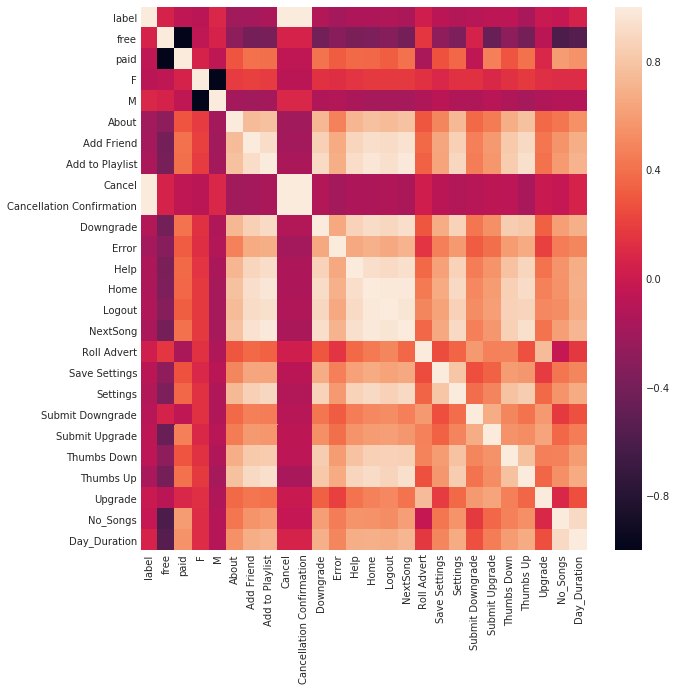

In [76]:
# calculate the correlation matrix
corr = df_final.toPandas().corr()

# plot the correlation heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax)

### First experimentation with Logistic Regression

In [77]:
# Define the features for the classification model
feature_cols = df_final.columns[2:]
# feature_cols.remove('Logout')
# feature_cols.remove('Home')
feature_cols.remove('Cancellation Confirmation')
feature_cols.remove('Cancel')

We experimented also with a small number of features (the ones with high correlation were removed). However, we got the best results using all features 

In [37]:
# Create a vector assembler for the relevant features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
vector_df = assembler.transform(df_final)

In [37]:
# Check how the vector looks like
vector_df.head(2)

[Row(userId='100010', label=0, free=1, paid=0, F=1, M=0, About=1, Add Friend=4, Add to Playlist=7, Cancel=0, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, Logout=5, NextSong=275, Roll Advert=52, Save Settings=0, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, No_Songs=39.142857142857146, Day_Duration=9269.0, features=DenseVector([1.0, 0.0, 1.0, 0.0, 1.0, 4.0, 7.0, 0.0, 0.0, 2.0, 11.0, 5.0, 275.0, 52.0, 0.0, 0.0, 0.0, 0.0, 5.0, 17.0, 2.0, 39.1429, 9269.0])),
 Row(userId='200002', label=0, free=0, paid=1, F=0, M=1, About=3, Add Friend=4, Add to Playlist=8, Cancel=0, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, Logout=5, NextSong=387, Roll Advert=7, Save Settings=0, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, No_Songs=55.0, Day_Duration=13668.57142857143, features=DenseVector([0.0, 1.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 0.0, 2.0, 20.0, 5.0, 387.0, 7.0, 0.0, 3.0,

In [38]:
# Create a MinMaxScaler so that all values in the vector are between 0 and 1
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scale_model = scaler.fit(vector_df.select("features"))
scale_df = scale_model.transform(vector_df)

In [39]:
# Check how the scaled vector looks like
scale_df.select('features', 'scaledFeatures').head(2)

[Row(features=DenseVector([1.0, 0.0, 1.0, 0.0, 1.0, 4.0, 7.0, 0.0, 0.0, 2.0, 11.0, 5.0, 275.0, 52.0, 0.0, 0.0, 0.0, 0.0, 5.0, 17.0, 2.0, 39.1429, 9269.0]), scaledFeatures=DenseVector([1.0, 0.0, 1.0, 0.0, 0.04, 0.028, 0.0292, 0.0, 0.0, 0.0435, 0.031, 0.0403, 0.034, 0.4062, 0.0, 0.0, 0.0, 0.0, 0.0667, 0.0389, 0.1333, 0.2325, 0.1659])),
 Row(features=DenseVector([0.0, 1.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 0.0, 2.0, 20.0, 5.0, 387.0, 7.0, 0.0, 3.0, 0.0, 1.0, 6.0, 21.0, 2.0, 55.0, 13668.5714]), scaledFeatures=DenseVector([0.0, 1.0, 0.0, 1.0, 0.12, 0.028, 0.0333, 0.0685, 0.0, 0.0435, 0.0563, 0.0403, 0.048, 0.0547, 0.0, 0.0577, 0.0, 0.25, 0.08, 0.0481, 0.1333, 0.3345, 0.2484]))]

In [40]:
# Select only the relevant field for the model (features vector and label)
df_cl = scale_df.select('scaledFeatures', 'label')

In [41]:
# Prepare the logistic regression model
lr =  LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=0.0, elasticNetParam=0)

In [42]:
# Train the model
lr_model = lr.fit(df_cl)

In [43]:
# Get the summary statistics of the model
summary = lr_model.summary

In [44]:
# Get the accuracy
summary.accuracy

0.7866666666666666

In [45]:
# Get a snapshot of the predictions
summary.predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|      scaledFeatures|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,0.0,1.0,0.0,...|  0.0|[0.93808591823398...|[0.71871285972398...|       0.0|
|[0.0,1.0,0.0,1.0,...|  0.0|[1.87059515393037...|[0.86652712671669...|       0.0|
|[1.0,0.0,0.0,1.0,...|  1.0|[1.54640368508975...|[0.82439370515009...|       0.0|
|[0.0,1.0,1.0,0.0,...|  0.0|[6.77246847092840...|[0.99885644412340...|       0.0|
|[0.0,1.0,0.0,1.0,...|  1.0|[0.25028407775576...|[0.56224642086817...|       0.0|
|[1.0,0.0,0.0,1.0,...|  0.0|[1.53950481970503...|[0.82339272904799...|       0.0|
|[0.0,1.0,0.0,1.0,...|  0.0|[1.76585341521188...|[0.85394124447830...|       0.0|
|[0.0,1.0,1.0,0.0,...|  1.0|[-0.3264562347269...|[0.41910312483350...|       1.0|
|[0.0,1.0,1.0,0.0,...|  0.0|[1.65358071550533...|[0.83937440729359...|       0.0|
|[0.0,1.0,0.0,1.

## Testing different models

#### Split into rest (train and test) and validation sets

In [78]:
rest, validation = df_final.randomSplit([0.8, 0.2], seed=42)

In [79]:
# Prepare assembler, scaler and the F1 evaluator for all models
assembler = VectorAssembler(inputCols=feature_cols, outputCol='vec_features')
scaler = MinMaxScaler(inputCol='vec_features', outputCol='scaled_features')
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

#### Test Logistic Regression

In [72]:
# Define the logistic regression model for fine tuning
lr =  LogisticRegression(featuresCol='scaled_features', elasticNetParam=0)

pipeline = Pipeline(stages=[assembler, scaler, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.01, 0.05, 0.1]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.maxIter, [10, 15]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [73]:
# Train the model and measure time efficiency
t1 = time.time()
cvModel_lr = crossval.fit(rest)
t2 = time.time()
print('Fitting the model took {} minutes'.format((t2 - t1) / 60.0))

Fitting the model took 32.14635683298111 minutes


In [74]:
# Get metrics for crossvalidation
cvModel_lr.avgMetrics

[0.7345799988613436,
 0.7190050078146545,
 0.7345799988613436,
 0.7190050078146545,
 0.6964808936350945,
 0.6838493564421538,
 0.6865793591721565,
 0.6865793591721565,
 0.6831619510764826,
 0.6831619510764826,
 0.680528154194898,
 0.6933400802658799]

In [75]:
# Get parameters of the best model in the crossvalidation
bestPipeline_lr = cvModel_lr.bestModel
bestModel_lr = bestPipeline_lr.stages[2]
bestPa rams_lr = bestModel_lr.extractParamMap()
for k, v in bestParams_lr.items():
    print('{}: {}'.format(k.name, v))

aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: scaled_features
fitIntercept: False
labelCol: label
maxIter: 10
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


In [76]:
# Predict using the validation set
results_lr = bestPipeline_lr.transform(validation)

In [78]:
# Get accuracy of the validation set
f1_evaluator.evaluate(results_lr.select(['label', 'prediction']), {f1_evaluator.metricName: 'accuracy'})

0.7941176470588235

In [79]:
# Get F1 score of the validation set
f1_evaluator.evaluate(results_lr)

0.7262656475019387

#### Test Random Forest Classification

In [80]:
# Define the random forest model for fine tuning
rf = RandomForestClassifier(featuresCol='scaled_features')

pipeline = Pipeline(stages=[assembler, scaler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .addGrid(rf.maxDepth,[int(x) for x in np.linspace(start = 5, stop = 10, num = 2)]) \
    .addGrid(rf.subsamplingRate,[x for x in np.linspace(start = 0.01, stop = 1, num = 3)]) \
    .build()

crossval_rd = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [81]:
# Train the model and measure time efficiency
t1 = time.time()
cvModel_rd = crossval_rd.fit(rest)
t2 = time.time()
print('Fitting the model took {} minutes'.format((t2 - t1) / 60.0)) 

Fitting the model took 40.393283331394194 minutes


In [82]:
# Get metrics for crossvalidation
cvModel_rd.avgMetrics

[0.6690411966110177,
 0.7288081814064541,
 0.6661642461716739,
 0.6690411966110177,
 0.7101349930125338,
 0.6636307163609324,
 0.6650076075046898,
 0.6723366920478853,
 0.6899516699394579,
 0.6650076075046898,
 0.6696924001587421,
 0.6595236481095739,
 0.6690411966110177,
 0.6787958152170596,
 0.6775905959939549,
 0.6690411966110177,
 0.6759875124087567,
 0.6766139371167846]

In [83]:
# Get parameters of the best model in the crossvalidation
bestPipeline_rd = cvModel_rd.bestModel
bestLRModel_rd = bestPipeline_rd.stages[2]
bestParams_rd = bestLRModel_rd.extractParamMap()
for k, v in bestParams_rd.items():
    print('{}: {}'.format(k.name, v))

cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: scaled_features
impurity: gini
labelCol: label
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
numTrees: 5
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 760658399392429169
subsamplingRate: 0.505


In [84]:
# Predict using the validation set
results_rd = cvModel_rd.bestModel.transform(validation)

In [85]:
# Get accuracy of the validation set
f1_evaluator.evaluate(results_rd.select(['label', 'prediction']), {f1_evaluator.metricName: 'accuracy'})

0.7352941176470589

In [86]:
# Get F1 score of the validation set
f1_evaluator.evaluate(results_rd)

0.6480558325024925

#### Test the Gradient-boosted tree classifier

In [41]:
# Define the gradinet-boosted tree model for fine tuning
gbt = GBTClassifier(featuresCol='scaled_features')
#max_depths = np.linspace(1, 32, 32, endpoint=True)
pipeline = Pipeline(stages=[assembler, scaler, gbt])

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [int(x) for x in np.linspace(start = 5, stop = 20, num = 2)]) \
    .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(10, 30, 2, endpoint=True)]) \
    .build()

crossval_gbt = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [42]:
# Train the model and measure time efficiency
t1 = time.time()
cvModel_gbt = crossval_gbt.fit(rest)
t2 = time.time()
print('Fitting the model took {} minutes'.format((t2 - t1) / 60.0))

Fitting the model took 105.65863548517227 minutes


In [44]:
# Get metrics for crossvalidation
cvModel_gbt.avgMetrics

[0.7182239793697653, 0.713607404481518, 0.7242501501435376, 0.713607404481518]

In [47]:
# Get parameters of the best model in the crossvalidation
bestPipeline_gbt = cvModel_gbt.bestModel
bestLRModel_gbt = bestPipeline_gbt.stages[2]
bestParams_gbt = bestLRModel_gbt.extractParamMap()
for k, v in bestParams_gbt.items():
    print('{}: {}'.format(k.name, v))

cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: scaled_features
labelCol: label
lossType: logistic
maxBins: 32
maxDepth: 10
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
predictionCol: prediction
seed: 2065291258700501668
stepSize: 0.1
subsamplingRate: 1.0


In [50]:
# Predict using the validation set
results_gbt = cvModel_gbt.bestModel.transform(validation)

In [54]:
# Get accuracy of the validation set
print(results_gbt.filter(results_gbt.label == results_gbt.prediction).count())
print(results_gbt.count())

22
34


In [1]:
22/34

0.6470588235294118

In [53]:
# Get F1 score of the validation set
f1_evaluator.evaluate(results_gbt)

0.6470588235294118

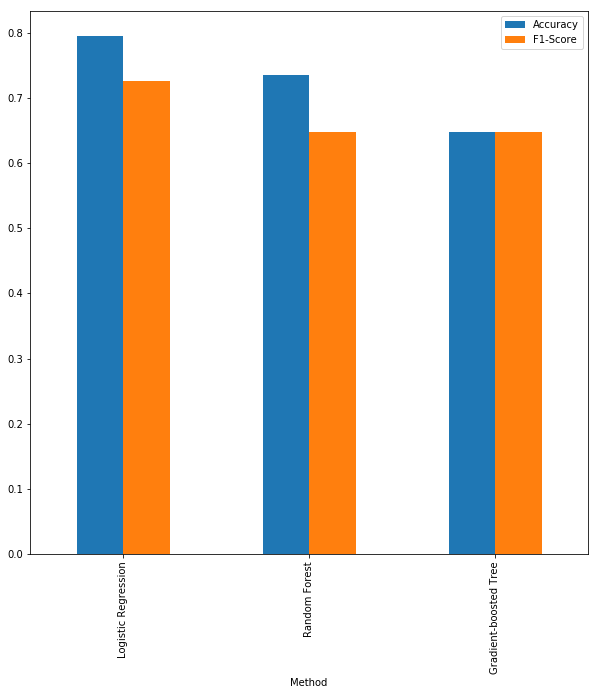

In [11]:
# Summarize results in one dataframe and plot
data = {1: ['Logistic Regression', 0.794, 0.726], 2: ['Random Forest', 0.735, 0.648], 3: ['Gradient-boosted Tree', 0.647, 0.647]}
results_pd = pd.DataFrame.from_dict(data, orient='index', columns=['Method', 'Accuracy', 'F1-Score'])

results_pd.plot(x='Method', y=["Accuracy", "F1-Score"], kind="bar",figsize=(10,10))
plt.show();

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.